In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import mlflow
import mlflow.sklearn

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing Important Libraries


import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
%matplotlib inline

In [3]:

import configparser
path_root="/home/cdsw"
config = configparser.ConfigParser()
config.read(f"{path_root}/parameters.conf")
data_lake_name=config.get("general","data_lake_name")
s3BucketName=config.get("general","s3BucketName")
train_tablename=config.get("general","train_tablename")
test_tablename=config.get("general","test_tablename")

database=config.get("general","database")
srcdir=s3BucketName

In [4]:
import cml.data_v1 as cmldata

# Sample in-code customization of spark configurations
#from pyspark import SparkContext
#SparkContext.setSystemProperty('spark.executor.cores', '1')
#SparkContext.setSystemProperty('spark.executor.memory', '2g')

CONNECTION_NAME = "go01-aw-dl"
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()


Setting spark.hadoop.yarn.resourcemanager.principal to jprosser


Spark Application Id:spark-application-1727188384257


Hive Session ID = 1865fb13-4da1-433c-b644-038bc6918dfc


+--------------------+
|           namespace|
+--------------------+
|         01_car_data|
|           01_car_dw|
|              adb101|
| airflow_dbt_example|
|            airlines|
|        airlines_csv|
|    airlines_iceberg|
|airlines_iceberg_...|
|      airlines_maint|
|      airlines_mjain|
|          airquality|
|           amallegni|
|          atlas_demo|
|            bankdemo|
|    banking_database|
|          bca_jps_l0|
|        bdl_airlines|
|    bdl_airlines_csv|
|  bdl_airlines_maint|
|             bme_raw|
+--------------------+
only showing top 20 rows



In [5]:
from __future__ import print_function
import os
import sys
from pyspark.sql import SparkSession
import time

In [6]:
spark = (
  SparkSession.builder.appName("CCLead-Data-Loader")
  .config("spark.sql.hive.hwc.execution.mode", "spark")
  .config("spark.sql.extensions", "com.qubole.spark.hiveacid.HiveAcidAutoConvertExtension, org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
  .config("spark.sql.catalog.spark_catalog.type", "hive")
  .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog")
  .config("spark.yarn.access.hadoopFileSystems", data_lake_name)
  .config("spark.hadoop.iceberg.engine.hive.enabled", "true")
  .config("spark.jars", "/opt/spark/optional-lib/iceberg-spark-runtime.jar")
  .getOrCreate()
  )

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()

+--------------------+
|           namespace|
+--------------------+
|         01_car_data|
|           01_car_dw|
|              adb101|
| airflow_dbt_example|
|            airlines|
|        airlines_csv|
|    airlines_iceberg|
|airlines_iceberg_...|
|      airlines_maint|
|      airlines_mjain|
|          airquality|
|           amallegni|
|          atlas_demo|
|            bankdemo|
|    banking_database|
|          bca_jps_l0|
|        bdl_airlines|
|    bdl_airlines_csv|
|  bdl_airlines_maint|
|             bme_raw|
+--------------------+
only showing top 20 rows



In [7]:
#CONNECTION_NAME = "<get Spark Data Lake connector name  from 'data' button in CML>"
first_snapshot=8157546807084176128

In [8]:
train = spark.read\
    .option("snapshot-id", first_snapshot)\
    .format("iceberg")\
    .load(f"{database}.{train_tablename}").toPandas()
    # show the number of rows - should be 2449
train.shape[0]

245725

In [9]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,DSYEP385,Female,32,RG260,Salaried,X1,32,No,307450,No,0
1,DWL8AOKU,Female,76,RG268,Other,X2,68,No,722546,Yes,0
2,FTPA66KP,Female,28,RG273,Salaried,X1,32,No,695152,No,0
3,5XHEBRTT,Female,26,RG251,Salaried,X3,21,No,499476,No,0
4,NVQYNSFZ,Male,27,RG268,Salaried,X1,20,No,860389,Yes,0


In [10]:
train.shape

(245725, 11)

In [11]:
test = spark.read\
    .format("iceberg")\
    .load(f"{database}.{test_tablename}").toPandas()
    # show the number of rows - should be 2449
test.shape[0]

105312

In [12]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,None,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [13]:
test.shape

(105312, 10)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int32 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int32 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int32 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int32 
dtypes: int32(4), object(7)
memory usage: 16.9+ MB


*The above information shows that there are nine features to predict the customer's interests in the recommended credit cards.*

*In train dataset there are 245725 observations and 9 features and 1 target column.*

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int32 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int32 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int32 
 9   Is_Active            105312 non-null  object
dtypes: int32(3), object(7)
memory usage: 6.8+ MB


*The test dataset contains 105312 obsevations and 9 features.*

In [16]:
# Let's see a statistical summary of the numerical columns in the train and test dataset.

train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


***The above summary shows that the average age of the customers who are eligible to take credit cards is 43 and the minimum age is 23 and the maximum age is 85.***

***Vintage is how long the eligible customers have been on the bank records.The average is 3 year 8 months and the minimum is 7 months, the maximum year is 11 years(135 months)***

In [17]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


## *Data Preprocessing*

In [18]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,DSYEP385,Female,32,RG260,Salaried,X1,32,No,307450,No,0
1,DWL8AOKU,Female,76,RG268,Other,X2,68,No,722546,Yes,0
2,FTPA66KP,Female,28,RG273,Salaried,X1,32,No,695152,No,0
3,5XHEBRTT,Female,26,RG251,Salaried,X3,21,No,499476,No,0
4,NVQYNSFZ,Male,27,RG268,Salaried,X1,20,No,860389,Yes,0


In [19]:
# Replacing null values with 'Not Sure' for both train and test sets. Its al together creating new class

train['Credit_Product'] = train['Credit_Product'].fillna("Not Sure")
test['Credit_Product'] = test['Credit_Product'].fillna("Not Sure")
train[train['Credit_Product'] == 'Not Sure'].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
10,QIQ3ERRG,Female,60,RG276,Other,X2,37,Not Sure,1429767,Yes,0
12,CKRISFWM,Female,85,RG270,Other,X2,93,Not Sure,522910,No,1
38,T7POZCQA,Female,38,RG279,Self_Employed,X1,31,Not Sure,461233,No,1
53,72RRJU3J,Male,65,RG283,Other,X2,91,Not Sure,642713,Yes,0
54,Z5LTA3Q3,Male,64,RG254,Other,X2,98,Not Sure,975110,No,1


In [20]:
# Storing target value in 'Target' attribute for further usage

Target = pd.DataFrame(train['Is_Lead'])

In [21]:
# Dropping unwanted columns 

train = train.drop(['Is_Lead', 'ID'], axis = 1)
test = test.drop(['ID'], axis = 1)

print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (245725, 9)
Shape of test data: (105312, 9)


In [22]:
# Concat both sets to data file

data = pd.concat([train, test])
data.shape

(351037, 9)

In [23]:
# Trying to reduce skewnees by applying some operators 

data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance'])

data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,32,RG260,Salaried,X1,32,No,12.636068,No
1,Female,76,RG268,Other,X2,68,No,13.490536,Yes
2,Female,28,RG273,Salaried,X1,32,No,13.451886,No
3,Female,26,RG251,Salaried,X3,21,No,13.121315,No
4,Male,27,RG268,Salaried,X1,20,No,13.665140,Yes


In [24]:
# Getting numeric and categorical columns

data_num_cols = data._get_numeric_data().columns 
data_cat_cols = data.columns.difference(data_num_cols)
print("Numeric columns: ", data_num_cols)
print()
print("Categorical columns: ", data_cat_cols)

Numeric columns:  Index(['Age', 'Vintage', 'Avg_Account_Balance'], dtype='object')

Categorical columns:  Index(['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation',
       'Region_Code'],
      dtype='object')


In [25]:
#Separating both numeric and categorical data from set

data_num_data = data.loc[:, data_num_cols]
data_cat_data = data.loc[:, data_cat_cols]

print("Shape of num data:", data_num_data.shape)
print("Shape of cat data:", data_cat_data.shape)

Shape of num data: (351037, 3)
Shape of cat data: (351037, 6)


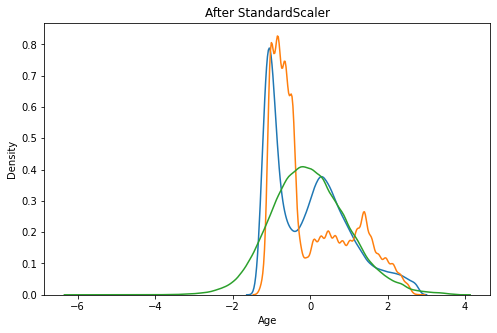

In [26]:
# Using StandardScaler to scale the data

from sklearn import preprocessing
s_scaler = preprocessing.StandardScaler()
data_num_data_s = s_scaler.fit_transform(data_num_data)

data_num_data_s = pd.DataFrame(data_num_data_s, columns = data_num_cols)

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After StandardScaler')

sns.kdeplot(data_num_data_s['Age'], ax=ax1)
sns.kdeplot(data_num_data_s['Vintage'], ax=ax1)
sns.kdeplot(data_num_data_s['Avg_Account_Balance'], ax=ax1);

***Handle Categorical Variable using Label Encoder***

In [27]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
data_cat_data = data_cat_data.apply(LabelEncoder().fit_transform)

In [28]:
# Storing cleaned data into 'data_new'

data_num_data_s.reset_index(drop=True, inplace=True)
data_cat_data.reset_index(drop=True, inplace=True)
#df = pd.concat([df1, df2], axis=1)
data_new = pd.concat([data_num_data_s, data_cat_data], axis = 1)

In [29]:
Target

,Is_Lead
0,0
1,0
2,0
3,0
4,0
...,...
245720,0
245721,0
245722,0
245723,0


In [30]:
# Splitting back the data into train and test

train_new = data_new.iloc[:245725,]
test_new = data_new.iloc[245726:,]

print("Shape of train data:", train_new.shape)
print("Shape of test data:", test_new.shape)

Shape of train data: (245725, 9)
Shape of test data: (105311, 9)


In [31]:
train_new.isnull().sum()

Age                    0
Vintage                0
Avg_Account_Balance    0
Channel_Code           0
Credit_Product         0
Gender                 0
Is_Active              0
Occupation             0
Region_Code            0
dtype: int64

In [32]:
train_new.dtypes

Age                    float64
Vintage                float64
Avg_Account_Balance    float64
Channel_Code             int64
Credit_Product           int64
Gender                   int64
Is_Active                int64
Occupation               int64
Region_Code              int64
dtype: object

In [33]:
train_new.head

<bound method NDFrame.head of              Age   Vintage  Avg_Account_Balance  Channel_Code  Credit_Product  \
0      -0.799137 -0.461633            -1.769916             0               0   
1       2.165441  0.651910            -0.392800             1               0   
2      -1.068644 -0.461633            -0.455091             0               0   
3      -1.203397 -0.801882            -0.987861             2               0   
4      -1.136021 -0.832814            -0.111397             0               0   
...          ...       ...                  ...           ...             ...   
245720  0.481022  1.920111             1.186961             2               1   
245721 -1.136021 -0.987472            -0.106603             0               0   
245722 -1.203397 -1.049336            -0.512901             0               0   
245723 -1.068644 -0.492564            -1.315849             0               0   
245724 -1.001267 -0.801882             0.326891             0               0  

In [34]:
# Split the dataset into training and testing set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new,Target,test_size=0.2,random_state=42)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196580, 9), (49145, 9), (196580, 1), (49145, 1))

## *Model Building*

In [38]:
# Now Ensemble Techniques (Bagging and Boosting)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [40]:
# Evaluate Model Performance

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay, auc

In [55]:
import mlflow
import mlflow.sklearn

In [56]:
mlflow.set_experiment("CC-lead-classifier")


2024/09/24 15:15:52 INFO mlflow.tracking.fluent: Experiment with name 'CC-lead-classifier' does not exist. Creating a new experiment.


<ActiveRun: >

In [ ]:
mlflow.start_run()

In [57]:
# Fitting random forest classifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/home/cdsw/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [58]:
rf_pred = rf.predict(X_test)

rf_auc = roc_auc_score(y_test, rf_pred)
rf_auc

0.7540909718806311

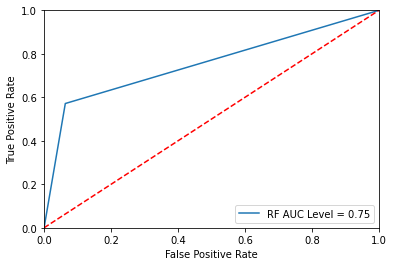

In [83]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, rf_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()



In [82]:

mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","RandomForestClassifier")
mlflow.log_metric("auc", rf_auc)
mlflow.log_figure(fig, "rf_auc.png")
mlflow.sklearn.log_model(rf, "rf_model")
  

In [85]:
np.save('data/rf_preds.npy', rf_pred)
        # Writes all files in "data" to root artifact_uri/states
mlflow.log_artifacts("data", artifact_path="rf_preds.npy")
## Artifacts are stored in project directory under /home/cdsw/.experiments/<experiment_id>/<run_id>/artifacts
mlflow.end_run()

In [86]:
# Start a new entry
mlflow.start_run()

<ActiveRun: >

In [87]:
# Fitting XGB Classifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
xgb_pred = rf.predict(X_test)

xgb_auc = roc_auc_score(y_test, rf_pred)
xgb_auc

0.7540909718806311

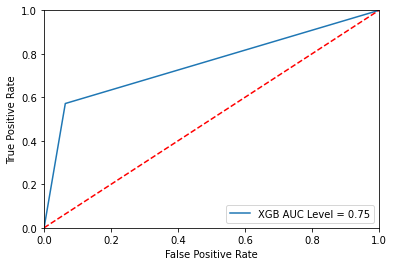

In [89]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, xgb_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='XGB AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()


In [90]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","XGBClassifier")
mlflow.log_metric("auc", xgb_auc)
mlflow.log_figure(fig, "xgb_auc.png")
mlflow.sklearn.log_model(xgb, "xgb_model")
  

In [99]:
np.save('data/xgb_preds.npy', xgb_pred)
        # Writes all files in "data" to root artifact_uri/states
mlflow.log_artifacts("data", artifact_path="xgb_preds.npy")
## Artifacts are stored in project directory under /home/cdsw/.experiments/<experiment_id>/<run_id>/artifacts
mlflow.end_run()

## *Model Performance Improvement*

In [100]:
# Start a new entry
mlflow.start_run()

<ActiveRun: >

In [101]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(train_new,Target)

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [103]:
# Fitting random forest classifier on balanced dataset

rfb = RandomForestClassifier()
rfb.fit(X_train, y_train)

/home/cdsw/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [104]:
rfb_pred = rfb.predict(X_test)

rfb_auc = roc_auc_score(y_test, rfb_pred)
rfb_auc

0.8926574656849883

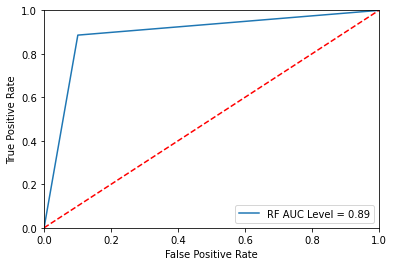

In [105]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, rfb_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()


In [106]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","RFBClassifier")
mlflow.log_metric("auc", rfb_auc)
mlflow.log_figure(fig, "rfb_auc.png")
mlflow.sklearn.log_model(rfb, "rfb_model")


In [107]:
np.save('data/rfb_preds.npy', rfb_pred)
        # Writes all files in "data" to root artifact_uri/states
mlflow.log_artifacts("data", artifact_path="rfb_preds.npy")
## Artifacts are stored in project directory under /home/cdsw/.experiments/<experiment_id>/<run_id>/artifacts
mlflow.end_run()

In [108]:
# Start a new entry
mlflow.start_run()

<ActiveRun: >

In [109]:
# Fitting LightGBM on balance data

from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 149950, number of negative: 149949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 299899, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007


LGBMClassifier()

In [110]:
lgb_predict = lgb.predict(X_test)

In [111]:
lgb_auc_score = roc_auc_score(y_test, lgb_predict)
lgb_auc_score

0.8972320733159327

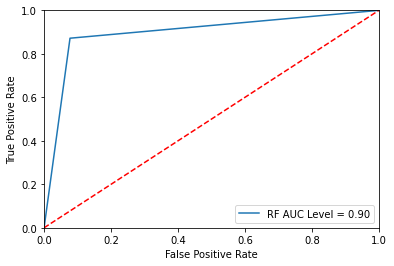

In [113]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, lgb_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()

In [115]:
np.save('data/lgb_preds.npy', rfb_pred)
        # Writes all files in "data" to root artifact_uri/states
mlflow.log_artifacts("data", artifact_path="lgb_preds.npy")
## Artifacts are stored in project directory under /home/cdsw/.experiments/<experiment_id>/<run_id>/artifacts
mlflow.end_run()

In [136]:
# Start a new entry
mlflow.start_run()

Exception: Run with UUID ywht-41ab-1jba-fhb4 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [125]:
# Fitting XGB Classifier on balanced dataset

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [137]:
xgb_predict = model.predict(X_test)

In [138]:
xgb_auc_score = roc_auc_score(y_test, xgb_predict)
xgb_auc_score

0.8796261324640059

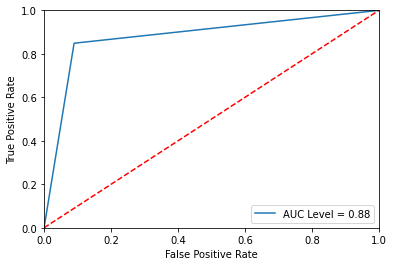

In [139]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, xgb_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [140]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","XGBBClassifier")
mlflow.log_metric("auc", xgb_auc_score)
mlflow.log_figure(fig, "xgb_auc.png")
mlflow.sklearn.log_model(model, "xgb_model")

In [141]:
subdir="xgbb"
directory = os.path.dirname(f"data/{subdir}")
os.makedirs(directory, exist_ok=True)
np.save(f"data/{subdir}/{subdir}_preds.npy", xgb_predict)
        # Writes all files in "data" to root artifact_uri/states
mlflow.log_artifacts(f"data/{subdir}", artifact_path=f"{subdir}_pred")
## Artifacts are stored in project directory under /home/cdsw/.experiments/<experiment_id>/<run_id>/artifacts
mlflow.end_run()

FileNotFoundError: [Errno 2] No such file or directory: 'data/xgbb/xgbb_preds.npy'

***Since Area Under the Curve is 90% which indicates that model performance is excellent and need no improvement at all.***